# MVG Rad

Let's explore the data MVG Rad data.




## Setup

### Imports

First, let's import the libraries that we need.

In [1]:
import datetime
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
import polars as pl
from cartopy.io.img_tiles import OSM
from matplotlib.offsetbox import AnchoredText
from pyproj import Geod
from scipy import ndimage

### Parameters

The raw data contain a small amount of "bad" data, such invalid GPS coordinates.

To filtere these out, we define plausible ranges for valid data:

In [2]:
MIN_LAT = 48.0
MAX_LAT = 48.3
MIN_LON = 11.25
MAX_LON = 11.85

# Use this for a wider box that includes e.g. Freising and Wolfratshausen
# MIN_LAT = 47.9
# MAX_LAT = 48.45
# MIN_LON = 11.2
# MAX_LON = 12.0

### Load the data

Before running this, make sure that you have downloaded the raw data to the `raw-data` folder.

In [3]:
# Some of the numeric columns in the CSV file contain trailing spaces,
# Polars is unable to parse them, see https://github.com/pola-rs/polars/issues/14530
# So we need to read them as strings first, and then strip the spaces:
unparsed_data = pl.scan_csv(
    "raw-data/MVG_Rad_Fahrten_*.csv",
    separator=";",
    with_column_names=lambda names: [name.strip() for name in names],
    try_parse_dates=True,
)

all_rides = unparsed_data.select(
    pl.col("STARTTIME").alias("start_time"),
    pl.col("ENDTIME").alias("end_time"),
    pl.col("STARTLAT")
    .str.strip_chars()
    .str.replace(",", ".")
    .cast(pl.Float32)
    .alias("start_lat"),
    pl.col("STARTLON")
    .str.strip_chars()
    .str.replace(",", ".")
    .cast(pl.Float32)
    .alias("start_lon"),
    pl.col("ENDLAT")
    .str.strip_chars()
    .str.replace(",", ".")
    .cast(pl.Float32)
    .alias("end_lat"),
    pl.col("ENDLON")
    .str.strip_chars()
    .str.replace(",", ".")
    .cast(pl.Float32)
    .alias("end_lon"),
    pl.col("RENTAL_STATION_NAME").str.strip_chars().alias("start_station"),
    pl.col("RETURN_STATION_NAME").str.strip_chars().alias("end_station"),
)

### Enhance the data

Calculate some additional columns such as year, month, weekday, and time, as well as trip distance and duration.
These will enable us later to filter and group the data efficiently.

In [4]:
geod = Geod(ellps="WGS84")
all_rides = all_rides.collect()
distances = [
    geod.line_length(lats=[start_lat, end_lat], lons=[start_lon, end_lon]) / 1_000
    for start_lat, end_lat, start_lon, end_lon in zip(
        all_rides["start_lat"],
        all_rides["end_lat"],
        all_rides["start_lon"],
        all_rides["end_lon"],
    )
]

In [5]:
all_rides = all_rides.with_columns(
    year=pl.col("start_time").dt.year(),
    weekday=pl.col("start_time").dt.weekday(),
    time=pl.col("start_time").dt.time(),
    month=pl.col("start_time").dt.month(),
    distance=pl.Series(distances),
    duration=pl.col("end_time") - pl.col("start_time"),
)

In addition, let's calculate the set of stations

In [6]:
def get_stations(prefix: str):
    return (
        all_rides.group_by(station=f"{prefix}_station")
        .agg(
            pl.first(f"{prefix}_lat").alias("lat"),
            pl.first(f"{prefix}_lon").alias("lon"),
            pl.min("start_time"),
            pl.max("end_time"),
        )
        .filter(
            pl.col("station") != "",
            pl.col("lat").is_between(MIN_LAT, MAX_LAT),
            pl.col("lon").is_between(MIN_LON, MAX_LON),
        )
    )


stations = (
    pl.concat([get_stations("start"), get_stations("end")])
    .sort(pl.col("station"))
    .group_by("station")
    .agg(
        pl.mean("lat"),
        pl.mean("lon"),
        pl.min("start_time"),
        pl.max("end_time"),
    )
).sort("station")

## Basic investigations

### Rides per year

Let's start with a simple question: how many rides were there per year?

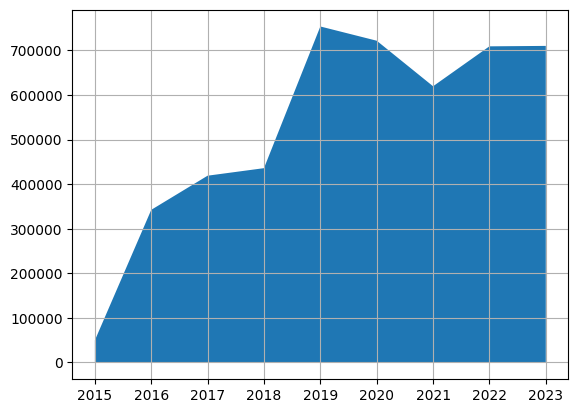

In [7]:
rides_by_year = (
    all_rides.select(pl.col("start_time").dt.year().alias("year"))
    .group_by("year")
    .agg(pl.len().alias("rides"))
    .sort("year")
)
fig, ax = plt.subplots()
ax.grid()
ax.fill_between(rides_by_year["year"], 0, rides_by_year["rides"])

### Travel distance and duration

How far do the rides go, and how long to they take?

Note that we don't know the actual distance travelled, only the distance between start and end points of a ride.
Since we generally can't ride as the crow flies, the actual distance will be larger.
And round trips will be tracked as distance zero.

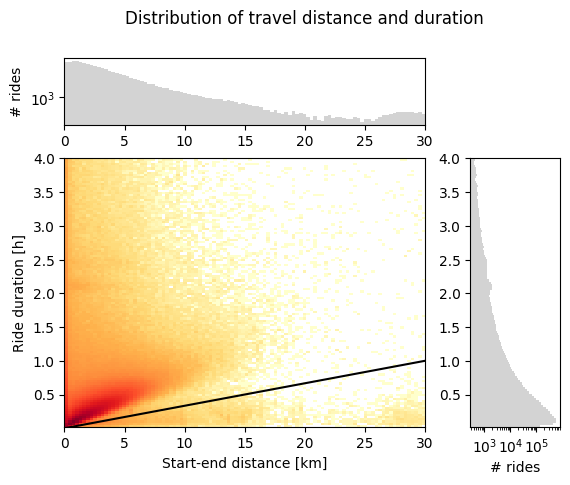

In [8]:
def draw_distance_duration(
    *,
    min_distance: float = 0.0,
    max_distance: float = 30.0,
    distance_bins: int = 100,
    min_duration: datetime.timedelta = datetime.timedelta(minutes=1),
    max_duration: datetime.timedelta = datetime.timedelta(hours=4),
    duration_bins: int = 120,
    speed_limit: float = 30,
):
    def duration_in_hours(td: datetime.timedelta) -> float:
        return td.seconds / 3_600

    distances = all_rides["distance"]
    distance_range = (min_distance, max_distance)

    durations = all_rides.with_columns(
        (pl.col("duration").dt.total_minutes() / 60).alias("hours")
    )["hours"]
    duration_range = (duration_in_hours(min_duration), duration_in_hours(max_duration))

    fig = plt.figure()
    fig.suptitle("Distribution of travel distance and duration")
    gs = fig.add_gridspec(2, 2, width_ratios=(4, 1), height_ratios=(1, 4))
    ax_2d = fig.add_subplot(gs[1, 0])
    ax_2d.hist2d(
        distances,
        durations,
        bins=(distance_bins, duration_bins),
        range=(distance_range, duration_range),
        norm="log",
        cmap="YlOrRd",
    )
    ax_2d.plot(
        (0, speed_limit * duration_range[-1]), (0, duration_range[-1]), c="black"
    )
    ax_2d.set_xlabel("Start-end distance [km]")
    ax_2d.set_ylabel("Ride duration [h]")

    ax_distances = fig.add_subplot(gs[0, 0], sharex=ax_2d)
    ax_distances.hist(
        distances, bins=distance_bins, range=distance_range, log=True, color="lightgrey"
    )
    ax_distances.set_ylabel("# rides")

    ax_durations = fig.add_subplot(gs[1, 1], sharey=ax_2d)
    ax_durations.hist(
        durations,
        bins=duration_bins,
        range=duration_range,
        log=True,
        color="lightgrey",
        orientation="horizontal",
    )
    ax_durations.set_xlabel("# rides")


draw_distance_duration()

Some interesting observations:

* Many rides appear to be unrealistically fast.
  The black line corresponds to a speed of 30 km/h, which is pretty fast.
  Everything below that line is even faster, which is not plausible.
  Most likely, this is caused by incorrect GPS coordinates.
  By contrast, time is most likely correct in most cases, since it can be measured server-side.
  Also, ride fares depend on ride duration, so wrong time measurements would probably cause lots of complaints.
* See the thin red line at distance = 0? These are the round trips.

In [9]:
all_rides.filter(pl.col("distance") > 50_000).describe()

statistic,start_time,end_time,start_lat,start_lon,end_lat,end_lon,start_station,end_station,year,weekday,time,month,distance,duration
str,str,str,f64,f64,f64,f64,str,str,f64,f64,str,f64,f64,str
"""count""","""0""","""0""",0.0,0.0,0.0,0.0,"""0""","""0""",0.0,0.0,"""0""",0.0,0.0,"""0"""
"""null_count""","""0""","""0""",0.0,0.0,0.0,0.0,"""0""","""0""",0.0,0.0,"""0""",0.0,0.0,"""0"""
"""mean""",null,null,null,null,null,null,null,null,null,null,null,null,null,null
"""std""",null,null,null,null,null,null,null,null,null,null,null,null,null,null
"""min""",null,null,null,null,null,null,null,null,null,null,null,null,null,null
"""25%""",null,null,null,null,null,null,null,null,null,null,null,null,null,null
"""50%""",null,null,null,null,null,null,null,null,null,null,null,null,null,null
"""75%""",null,null,null,null,null,null,null,null,null,null,null,null,null,null
"""max""",null,null,null,null,null,null,null,null,null,null,null,null,null,null


In [10]:
all_rides.filter(
    pl.col("start_lat").is_between(MIN_LAT, MAX_LAT),
    pl.col("start_lon").is_between(MIN_LON, MAX_LON),
    pl.col("end_lat").is_between(MIN_LAT, MAX_LAT),
    pl.col("end_lon").is_between(MIN_LON, MAX_LON),
).describe()

statistic,start_time,end_time,start_lat,start_lon,end_lat,end_lon,start_station,end_station,year,weekday,time,month,distance,duration
str,str,str,f64,f64,f64,f64,str,str,f64,f64,str,f64,f64,str
"""count""","""4632670""","""4632670""",4.63267e6,4.63267e6,4.63267e6,4.63267e6,"""4632670""","""4632670""",4.63267e6,4.63267e6,"""4632670""",4.63267e6,4.63267e6,"""4632670"""
"""null_count""","""0""","""0""",0.0,0.0,0.0,0.0,"""0""","""0""",0.0,0.0,"""0""",0.0,0.0,"""0"""
"""mean""","""2020-06-24 19:15:45.815160""","""2020-06-24 19:46:31.991940""",48.146069,11.567739,48.146221,11.567758,null,null,2019.955848,3.984857,"""14:43:49.412567""",6.814271,1.872528,"""0:30:46.176779"""
"""std""",null,null,0.029039,0.037758,0.028975,0.037922,null,null,2.178179,1.946822,null,2.849409,1.663883,null
"""min""","""2015-10-09 09:54:00""","""2015-10-09 10:25:00""",48.0,11.25067,48.0,11.25067,"""""","""""",2015.0,1.0,"""00:00:00""",1.0,0.0,"""-1 day, 23:03:00"""
"""25%""","""2018-11-09 19:21:00""","""2018-11-09 19:46:00""",48.12994,11.54865,48.13002,11.5487,null,null,2018.0,2.0,"""11:12:00""",5.0,0.754241,"""0:07:00"""
"""50%""","""2020-07-30 20:09:00""","""2020-07-30 20:36:00""",48.14592,11.56793,48.14592,11.56805,null,null,2020.0,4.0,"""15:41:00""",7.0,1.434193,"""0:11:00"""
"""75%""","""2022-05-28 17:12:00""","""2022-05-28 17:47:00""",48.160568,11.58545,48.160648,11.58546,null,null,2022.0,6.0,"""18:40:00""",9.0,2.525552,"""0:19:00"""
"""max""","""2023-12-31 23:54:00""","""2024-01-01 16:00:00""",48.299141,11.84742,48.299229,11.84742,"""astopark""","""recording_4158318""",2023.0,7.0,"""23:59:00""",12.0,30.137067,"""144 days, 16:40:00"""


## Mapping

Now, lets draw some maps

### Basic heatmap

This is a heatmap of ride frequence (based on the start location), with stations indicated by red dots.

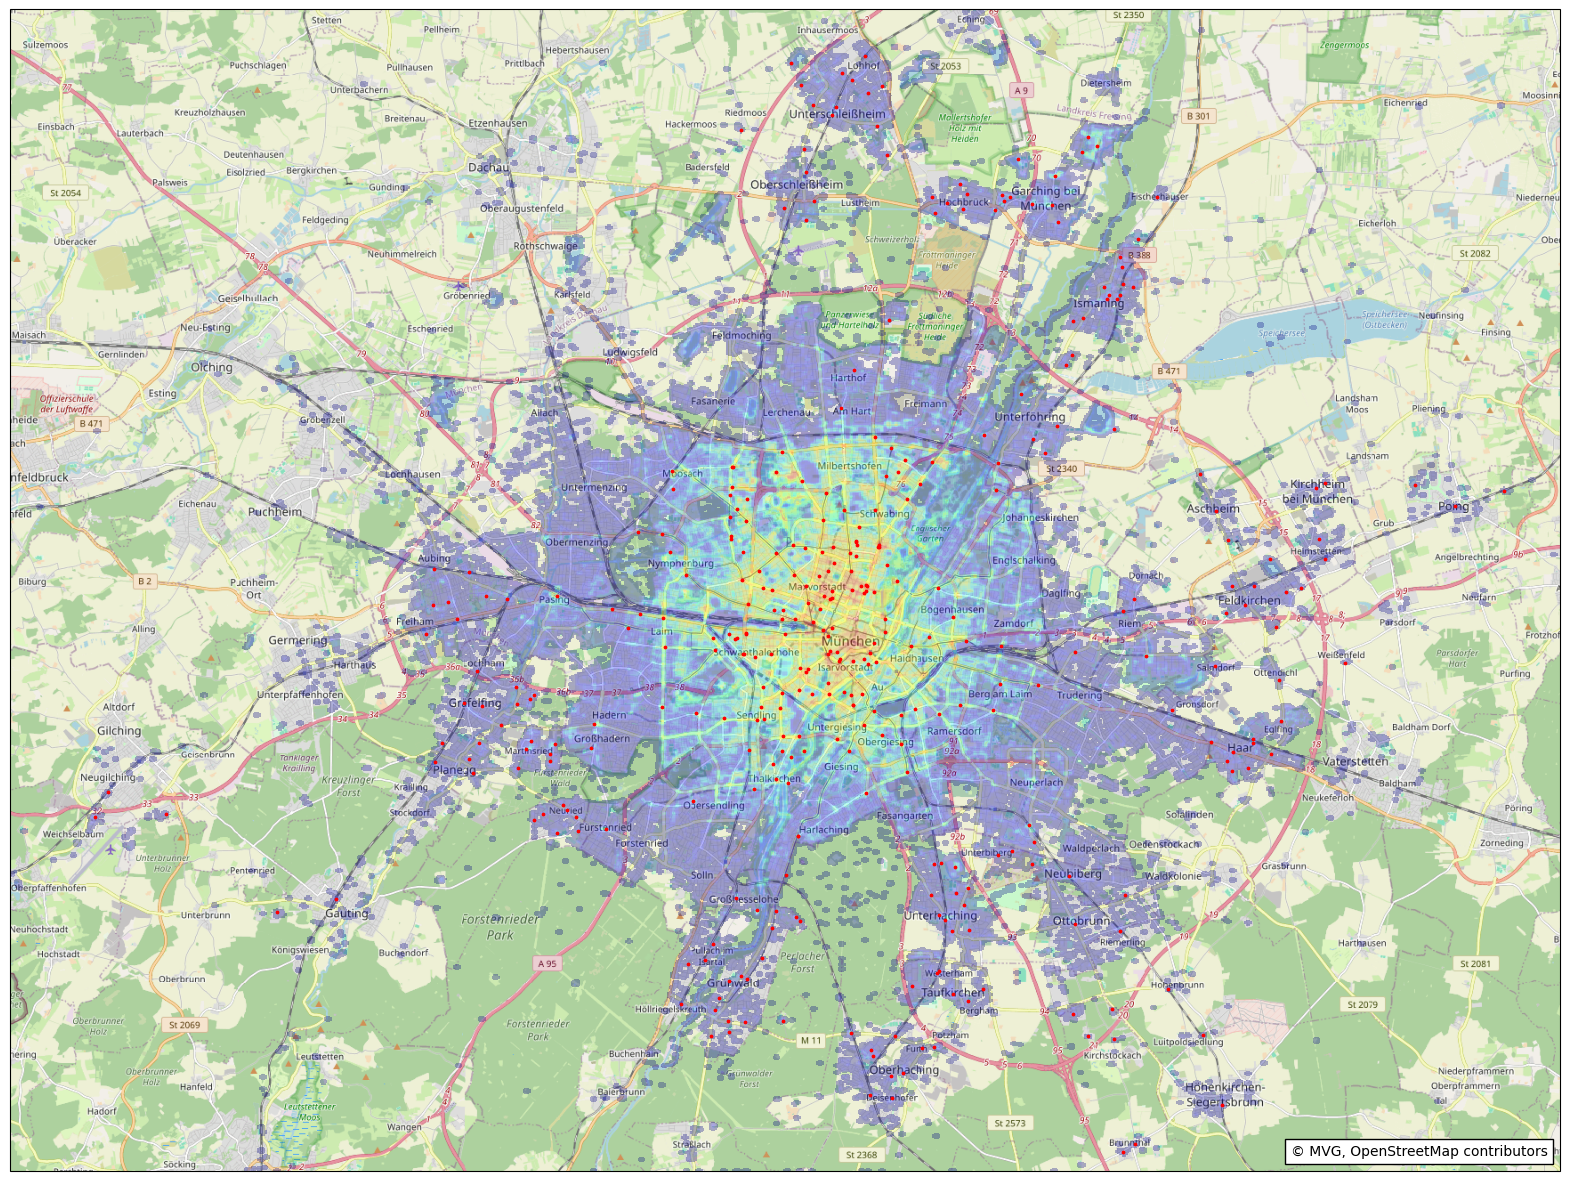

In [11]:
imagery = OSM(cache=True)

fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(1, 1, 1, projection=imagery.crs)
ax.set_extent([MIN_LON, MAX_LON, MIN_LAT, MAX_LAT], ccrs.PlateCarree())
ax.add_image(imagery, 12)
heatmap, _xedges, _yedges = np.histogram2d(
    all_rides["start_lon"],
    all_rides["start_lat"],
    bins=1000,
    range=((MIN_LON, MAX_LON), (MIN_LAT, MAX_LAT)),
)

logheatmap = np.arcsinh(heatmap)
logheatmap = ndimage.gaussian_filter(logheatmap, 1.0, mode="nearest")
lon = np.linspace(MIN_LON, MAX_LON, logheatmap.shape[0])
lat = np.linspace(MIN_LAT, MAX_LAT, logheatmap.shape[1])
logheatmap[logheatmap < 0.01] = None
Lat, Lon = np.meshgrid(lat, lon)
ax.pcolormesh(Lon, Lat, logheatmap, alpha=0.3, cmap="jet", transform=ccrs.PlateCarree())
ax.scatter(
    x=stations["lon"],
    y=stations["lat"],
    transform=ccrs.Geodetic(),
    s=3,
    c="red",
)
attribution = AnchoredText("© MVG, OpenStreetMap contributors", loc="lower right")
ax.add_artist(attribution)